# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import functools
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import wilcoxon, kendalltau
from utils import plot_longitudinal, get_diversity

# Set constants

In [2]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
rc("svg", fonttype="none") 

# Load data

In [3]:
study = "P65"

In [4]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [5]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1]).loc[study]
X.head()

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Hordeivirus|s__Barley_stripe_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cactus_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1
Sample Accession,,,,,,,,,,,,,,,,,,,,,
SAMEA104062441,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062442,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062443,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062444,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA104062445,0.02755,0.02755,0.02755,0.02755,0.02755,0.026885,0.026885,0.000665,0.000665,0.0,...,0,0,0,0,0,0,0,0,0,0


# Compute GMHI2 scores

In [6]:
meta = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata_val.csv"), index_col=[0, 1, 2]).loc[study]
assert((meta.index.get_level_values(0) == X.index).all())
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta.index = meta.index.get_level_values(1)
meta.head()

,health_status/host_diet,timepoint,GMHI2
Subject_ID,,,
ERAS10,Healthy,D0,2.518271
ERAS10,Healthy,D180,-1.046041
ERAS10,Healthy,D42,-0.258005
ERAS10,Healthy,D8,-1.006376
ERAS11,Healthy,D0,2.455387


# Compute other indices

In [7]:
meta = get_diversity(meta, X)
meta.head()

/Users/daniel/opt/anaconda3/envs/gmwi2_analysis/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
Subject_ID,,,,,,
ERAS10,Healthy,D0,2.518271,93,2.668180,0.157368
ERAS10,Healthy,D180,-1.046041,70,1.813468,0.308803
ERAS10,Healthy,D42,-0.258005,59,1.469658,0.427027
ERAS10,Healthy,D8,-1.006376,49,1.833790,0.253631
ERAS11,Healthy,D0,2.455387,106,3.100645,0.058934


# Plot stuff now 

In [8]:
meta["timepoint_plot"] = [int(time[1:]) for time in meta["timepoint"]]
meta["timepoint_plot"] = meta["timepoint_plot"].apply(lambda x : {0 : 0, 4 : 1, 8 : 2, 42 : 3, 180 : 4}[x])
meta.head()

,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity,timepoint_plot
Subject_ID,,,,,,,
ERAS10,Healthy,D0,2.518271,93,2.668180,0.157368,0
ERAS10,Healthy,D180,-1.046041,70,1.813468,0.308803,4
ERAS10,Healthy,D42,-0.258005,59,1.469658,0.427027,3
ERAS10,Healthy,D8,-1.006376,49,1.833790,0.253631,2
ERAS11,Healthy,D0,2.455387,106,3.100645,0.058934,0


In [9]:
timepoints_sorted = sorted(list(meta["timepoint"].unique()), key=lambda x : int(x[1:]))
timepoints_sorted

['D0', 'D4', 'D8', 'D42', 'D180']

In [10]:
indices = ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]

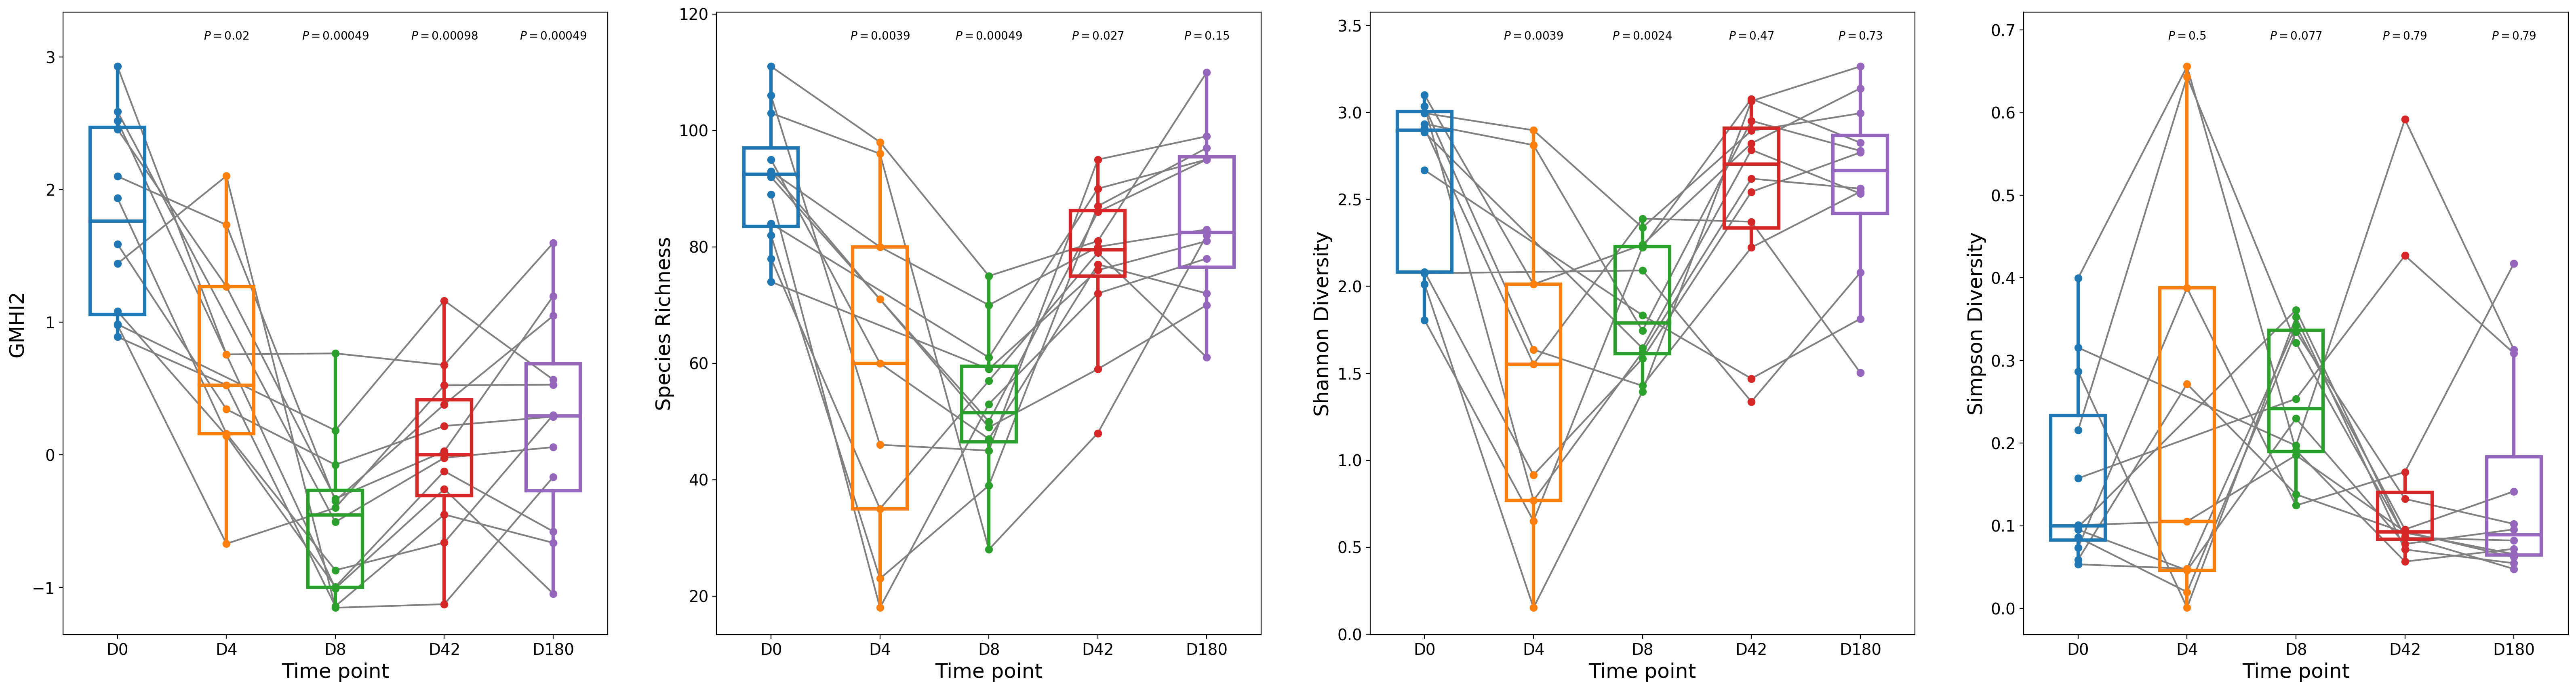

In [11]:
import warnings
warnings.filterwarnings('ignore')

plot_longitudinal(meta, indices, timepoints_sorted, study, show_tau=False)

In [12]:
timepoint_info = meta[["timepoint", "GMHI2", "Species Richness", "Shannon Diversity"]]
timepoint_info

,timepoint,GMHI2,Species Richness,Shannon Diversity
Subject_ID,,,,
ERAS10,D0,2.518271,93,2.668180
ERAS10,D180,-1.046041,70,1.813468
ERAS10,D42,-0.258005,59,1.469658
ERAS10,D8,-1.006376,49,1.833790
ERAS11,D0,2.455387,106,3.100645
ERAS11,D180,1.196903,99,3.138605
ERAS11,D42,0.027100,95,2.821837
ERAS11,D4,1.268980,46,2.011845
ERAS11,D8,-0.330039,45,2.239304


In [13]:
timepoint_info.to_csv(os.path.join(config.FIG_DATA_DIR, "2d_abx_intervention.csv"))

In [14]:
# sanity check plots

for index in ["GMHI2", "Species Richness", "Shannon Diversity", "Simpson Diversity"]:
    for t in ["D4", "D8", "D42", "D180"]:
        a = meta[meta["timepoint"] == "D0"].sort_index()[index]
        b = meta[meta["timepoint"] == t].sort_index()[index]
        both = set(a.index) & set(b.index)
        a = a.loc[both]
        b = b.loc[both]
        print(wilcoxon(a, b))
    print()

WilcoxonResult(statistic=3.0, pvalue=0.01953125)
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
WilcoxonResult(statistic=1.0, pvalue=0.0009765625)
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)

WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
WilcoxonResult(statistic=10.5, pvalue=0.02685546875)
WilcoxonResult(statistic=20.0, pvalue=0.1513671875)

WilcoxonResult(statistic=0.0, pvalue=0.00390625)
WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
WilcoxonResult(statistic=29.0, pvalue=0.4697265625)
WilcoxonResult(statistic=34.0, pvalue=0.7333984375)

WilcoxonResult(statistic=16.0, pvalue=0.49609375)
WilcoxonResult(statistic=16.0, pvalue=0.0771484375)
WilcoxonResult(statistic=35.0, pvalue=0.791015625)
WilcoxonResult(statistic=35.0, pvalue=0.791015625)



In [15]:
timepoint_info.groupby("timepoint").count()

,GMHI2,Species Richness,Shannon Diversity
timepoint,,,
D0,12,12,12
D180,12,12,12
D4,9,9,9
D42,12,12,12
D8,12,12,12


In [59]:
index_info = {}

for index in ["GMHI2", "Species Richness", "Shannon Diversity"]:
    index_df = timepoint_info[[index, "timepoint"]].reset_index()
    index_df = index_df.sort_values("timepoint")
    pivoted = index_df.pivot("Subject_ID", "timepoint", index)
    pivoted = pivoted[["D0", "D4", "D8", "D42", "D180"]]
    pivoted = pivoted.loc[sorted(pivoted.index, key=lambda x : int(x[4:]))]
    print(index)
    display(pivoted)
    index_info[index] = pivoted

GMHI2


timepoint,D0,D4,D8,D42,D180
Subject_ID,,,,,
ERAS1,2.589232,NaN,-0.506102,-0.022489,0.058497
ERAS2,1.082835,0.144535,-0.994315,-0.122922,-0.577149
ERAS3,0.889476,0.526320,-1.141045,-0.449532,-0.662983
ERAS4,1.442071,2.103218,-1.152495,-1.125607,-0.166763
ERAS5,0.979637,-0.670096,-0.399138,0.524581,0.529523
ERAS6,2.928870,0.757856,0.765165,0.677655,1.597920
ERAS7,1.936347,0.160949,-0.869665,-0.661528,0.301179
ERAS8,0.984703,NaN,0.184352,1.163581,0.567487
ERAS9,2.100603,1.734265,-0.345654,0.380373,1.048198


Species Richness


timepoint,D0,D4,D8,D42,D180
Subject_ID,,,,,
ERAS1,74.0,NaN,59.0,76.0,81.0
ERAS2,89.0,18.0,53.0,72.0,78.0
ERAS3,103.0,96.0,28.0,48.0,82.0
ERAS4,111.0,98.0,75.0,81.0,110.0
ERAS5,95.0,60.0,47.0,77.0,72.0
ERAS6,82.0,23.0,39.0,87.0,97.0
ERAS7,93.0,80.0,70.0,80.0,83.0
ERAS8,84.0,NaN,61.0,90.0,95.0
ERAS9,92.0,71.0,50.0,86.0,95.0


Shannon Diversity


timepoint,D0,D4,D8,D42,D180
Subject_ID,,,,,
ERAS1,2.885959,NaN,1.644484,2.785075,2.533556
ERAS2,3.035084,0.769742,1.621721,2.619337,2.562366
ERAS3,3.034798,1.635878,1.428114,2.223434,2.544550
ERAS4,2.995525,2.897477,2.337901,2.894675,2.995186
ERAS5,2.083224,0.915260,1.584339,2.543332,2.769660
ERAS6,2.012842,0.151962,1.394064,3.065536,3.264488
ERAS7,2.909328,1.552845,2.389368,2.371570,1.503519
ERAS8,2.074849,NaN,2.091342,1.336625,2.078793
ERAS9,2.933829,2.812123,1.745322,2.952076,2.779342


In [60]:
pd.concat(index_info, names=["index"]).to_csv(os.path.join(config.LOG_DIR, "P65.csv"))